# Interpretable Machine Learning with SHAP Values

In [1]:
import pandas as pd
import lightgbm as lgb
import shap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

shap.initjs()

np.random.seed(1234)

#selected_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
X, y = shap.datasets.california()
#X = X[selected_features]

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# A Motivating Example: Linear Regression

Linear regression models are simply enough to be considered "intrinsically interpretable". The prediction from a linear model is simply the sum of the products of model coefficients and the variable values. 

$$
y = \beta_0 + \beta_1 x_1 + \dots + \beta_k x_k
$$

It might be tempting to use the magnitudes of the coefficients to determine the most important variables, this would provide a misleading understanding of the model if the units of measure of the variables are different. 

In the California housing dataset, median income is measured in tens of thousands of dollars and the coefficient is 0.54, which is a similar magnitude to the rest of the coefficients. However, if we measure median income in dollars, then coefficient would 5 orders of magnitude greater than the rest of the coefficients and would be deemed the "most important" by magnitude. 

In [3]:
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_train, y_train)

for name, c in zip(X_train.columns, linear_model.coef_.tolist()):
    print(f"{name}:  {c}")

MedInc:  0.4409217448084289
HouseAge:  0.009730149967873029
AveRooms:  -0.11641846019570788
AveBedrms:  0.7210824590885908
Population:  -4.1391979038463145e-06
AveOccup:  -0.0038520610320599454
Latitude:  -0.4147068147229453
Longitude:  -0.42921560131966396


There is a way to view the importance of each variable for an *individual prediction*. Since the predicted value of a linear model is a linear sum of coefficients multipled by the value of the variable (the $\beta_i  x_i$ terms in the sum), we can decompose the predictions into these products and view their magnitudes since they are all in the same unit of measure as the target variable.

In [11]:
# verify the sum of products equals the model predictions
np.allclose(
    np.multiply(X_test.values, linear_model.coef_).sum(axis=1) + linear_model.intercept_, # manually calculate predictions using sum of products
    linear_model.predict(X_test)                                                          # model predictions
)

True

In [14]:
# create a matrix of the products
linear_components = np.concatenate(
    [
        np.repeat(linear_model.intercept_, X_test.shape[0]).reshape((-1, 1)), 
        np.multiply(X_test.values, linear_model.coef_)
    ], 
axis = 1)

### A Few Charts



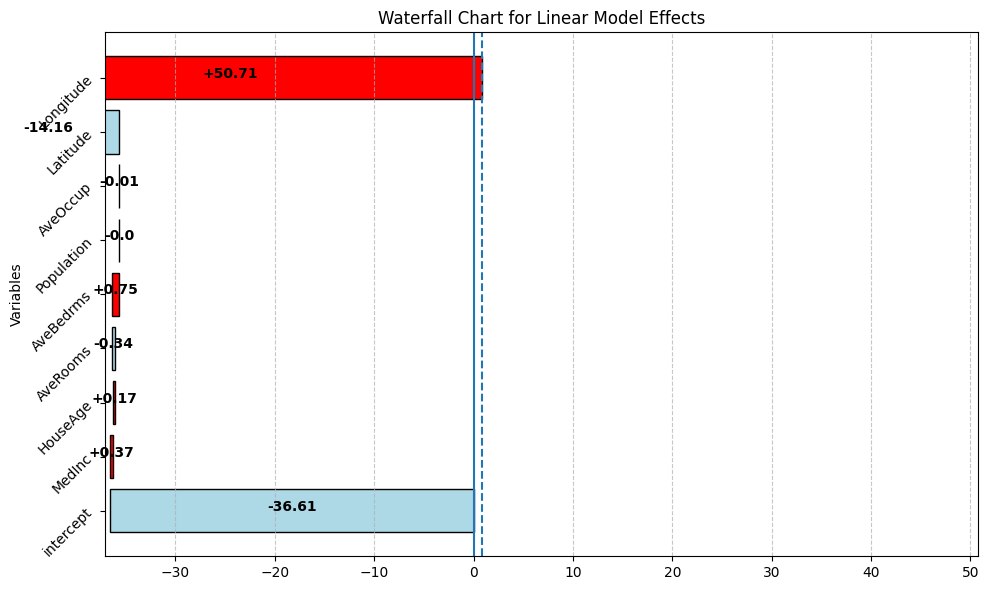

In [18]:
values = linear_components[105, :]
labels = ['intercept'] + [c for c in X.columns]

# Calculate the cumulative values
cumulative = np.cumsum(values)
cumulative = np.insert(cumulative, 0, 0)  # Insert a starting point of 0 for visual clarity

# The positions where each bar starts
starts = cumulative[:-1]

# Define colors for positive and negative changes
colors = ['red' if val >= 0 else 'lightblue' for val in values]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each bar
for i in range(len(values)):
    ax.barh(i, values[i], left=starts[i], color=colors[i], edgecolor='black')

# Add labels to each bar for clarity
for i in range(len(values)):
    ax.text(starts[i] + values[i] / 2, i, f'{round(values[i],2):+}', ha='center', color='black', fontweight='bold')

# Configure x-axis with labels
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, rotation=45, ha='right')

# Add labels and title
ax.set_ylabel('Variables')
ax.set_title('Waterfall Chart for Linear Model Effects')

# Add a grid for readability
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.set_xlim((values.min()-0.5, values.max()+0.05))
ax.axvline(values.sum(), linestyle='--')
ax.axvline(0)
# Show the plot
plt.tight_layout()
plt.show()

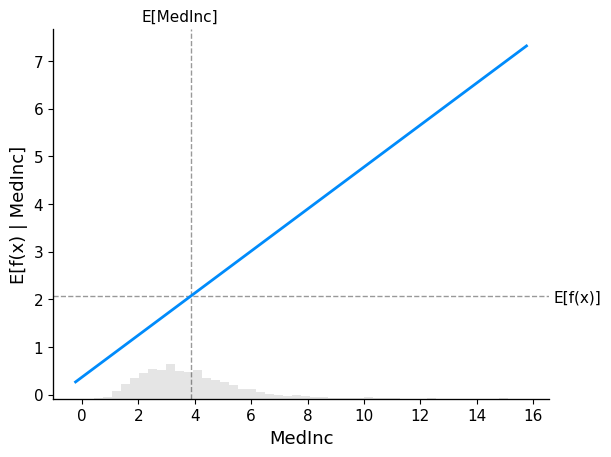

In [32]:
shap.partial_dependence_plot(
    "MedInc",
    linear_model.predict,
    X_test,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

## Introduction to SHAP Values

It would be useful if there were a similar additive decomposition for complex, non-linear models such as neural networks, random forests and boosted trees. Fortunately, there is. SHAP values stand

In [20]:
model = RandomForestRegressor(
    n_estimators = 75,
    criterion="squared_error",
    max_depth=4,
    min_samples_split=10,
    max_features="sqrt"
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

shap_model = shap.TreeExplainer(model)
shap_values = shap_model(X_test)

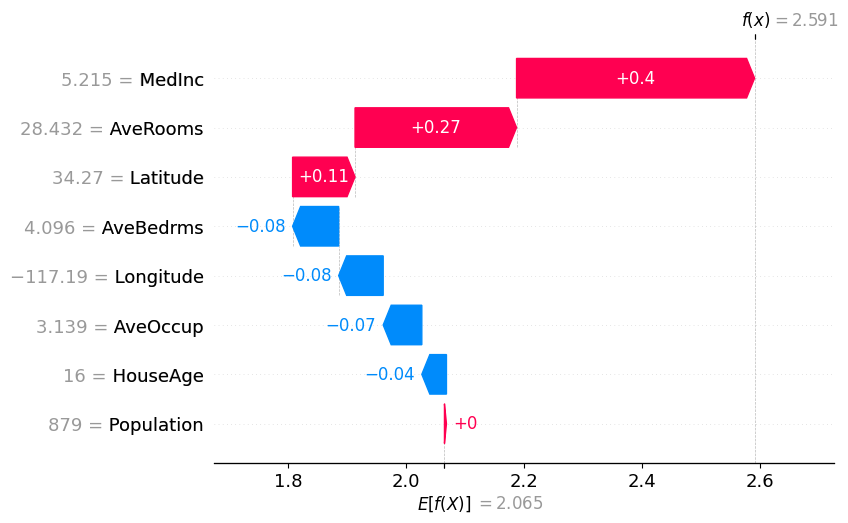

In [21]:
shap.plots.waterfall(shap_values[10, ...])

### The Definition of a SHAP Value

$$
\phi_i = \sum_{S\subseteq F/\{i\}}  \binom{|F|-1}{|S|}^{-1} \big[ f_{S\cup\{i\}} (x_{S\cup\{i\}}) - f_S(x_S) \big]
$$

where $\phi_0 = f_\empty(\empty)$

In words:

"A SHAP value is the marginal change in the model output obtained by adding the $i$ th feature, conditioned on the set of features $S$ already being in the model, averaged over all subsets $S \subset F$ not containing $i$ "

In [22]:
shap.plots.force(shap_values[10, ...])

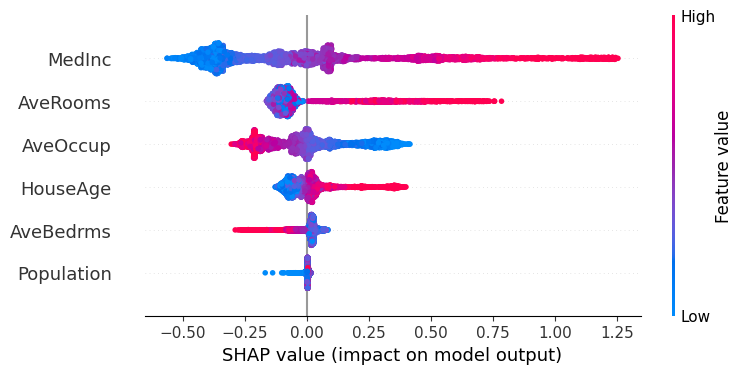

In [96]:
shap.plots.beeswarm(shap_values)

In [ ]:
# check that the sum of the SHAP values equals the model predictions
np.allclose(np.sum(shap_values.values, axis=1) + shap_model.expected_value, y_pred)

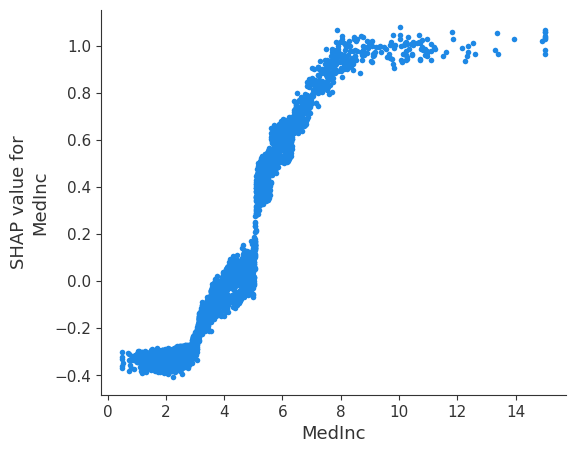

In [29]:
shap.dependence_plot("MedInc", shap_values.values, X_test, interaction_index=None)

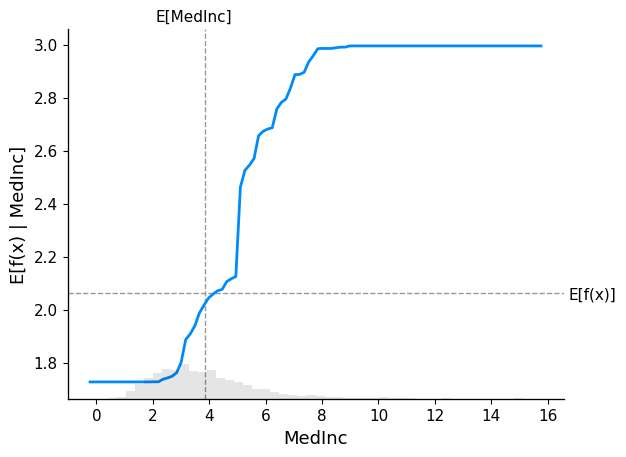

In [30]:
shap.partial_dependence_plot("MedInc", model.predict, X_test, ice=False, model_expected_value=True, feature_expected_value=True)

We can obtain "global" feature importances using SHAP values by averaging the magnitude of the SHAP values for each feature. 

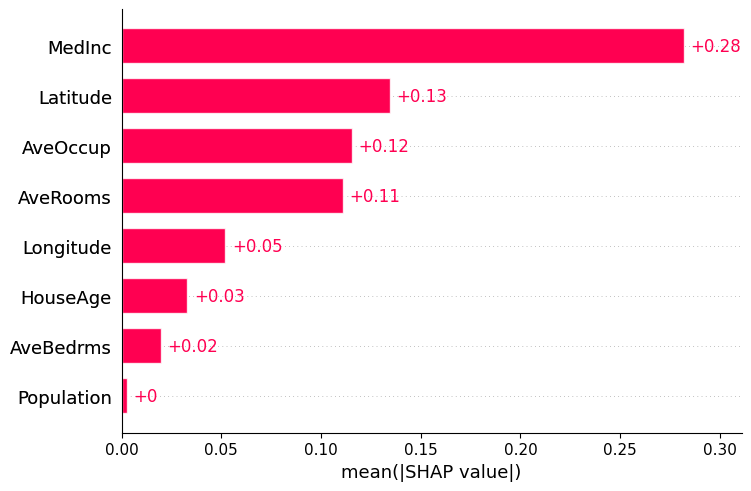

In [31]:
shap.plots.bar(shap_values)